# DNN for classification problem

# データ読み込み

In [1]:
import os
import json
import pandas as pd
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt

from chainer import training
from chainer.training import extensions

/Users/MEO/venv/study/lib/python3.6/site-packages/chainer/_environment_check.py:41: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  ''')  # NOQA


In [2]:
from sklearn.datasets import load_wine

In [3]:
df = pd.read_csv("/Users/MEO/Documents/self_study/data/Wine.csv", header=None)

colnames = [
    "Class",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline"]

df.columns = colnames

## 訓練データ用意

In [4]:
t = df.iloc[:, 0].values - 1
x = df.iloc[:, 1:].values
t = t.astype("i")
x = x.astype("f")

dataset = list(zip(x, t))

In [5]:
n_train = int(len(dataset)*0.7)
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)

## ネットワークモデル

In [6]:
class NN(chainer.Chain):
    def __init__(self, n_in=13, h1_nodes=10, h2_nodes=10, n_out=3):
        super().__init__()
        with self.init_scope():
            self.layer1 = L.Linear(None, h1_nodes)
            self.layer2 = L.Linear(None, h2_nodes)
            self.layer3 = L.Linear(None, n_out)
            self.bn = L.BatchNormalization(n_in)
            
    def __call__(self, x):
        h = self.bn(x)
        h = self.layer1(h)
        h = F.relu(h)
        h = self.layer2(h)
        h = F.relu(h)
        h = self.layer3(h)
        return h

np.random.seed(0)
nn = NN()
model = L.Classifier(nn)

## 訓練

In [7]:
batch_size = 10
epoch = 50

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [8]:
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/wine')
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy',
                                                         'main/loss', 'validation/main/loss', 'elapsed_time']))
# trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
#                                                         x_key='epoch', file_name='loss.png'))
# trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
#                                                         x_key='epoch', file_name='accuracy.png'))

In [9]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.392308       0.166667                  1.12546     1.11327               0.0885609     
2           0.433333       0.475                     1.07717     1.03084               0.158559      
3           0.415385       0.408333                  1.03339     0.979501              0.230406      
4           0.55           0.475                     0.971542    0.949204              0.293717      
5           0.5            0.575                     0.962307    0.91421               0.364779      
6           0.523077       0.591667                  0.92451     0.864566              0.433283      
7           0.6            0.625                     0.866175    0.837032              0.505996      
8           0.607692       0.658333                  0.838688    0.798051              0.576285      
9           0.65           0.833333                  0.789922    0.753908           

# visualization

In [10]:
with open('result/wine/log') as f:
    logs = json.load(f)

result = pd.DataFrame(logs)

In [11]:
result = pd.DataFrame(logs)

<Figure size 432x288 with 0 Axes>

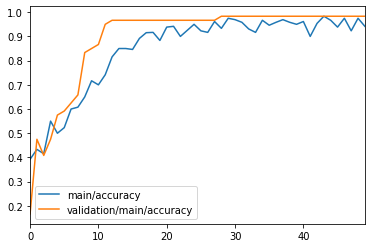

<Figure size 432x288 with 0 Axes>

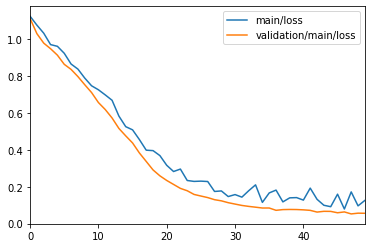

In [12]:
plt.figure()
result[['main/accuracy', 'validation/main/accuracy']].plot()

plt.figure()
result[['main/loss', 'validation/main/loss']].plot()

## Save model

In [13]:
os.makedirs('models', exist_ok=True)

In [14]:
chainer.serializers.save_npz('models/wine.npz', model)

## Inference

In [16]:
model = L.Classifier(NN())
chainer.serializers.load_npz('models/wine.npz', model)

x_new = x[0].reshape(1, -1)
y = model.predictor(x_new)
y = F.softmax(y)

np.argmax(y.array)

1